# Backtesting Framework. 

In [8]:
# Python module. 
import re, os 
import numpy as np 
import pandas as pd 
import pandas_datareader.data as web 
import matplotlib.pyplot as plt 
import pyfolio as pf 
import backtrader as bt 
from time import time 

# Change the current directory from (./notebook) to root directory. 
while not re.match(r".+MADS-CAP$", os.getcwd()): 
	os.chdir("..") 
	
print(f"Current directory: ({os.getcwd()})") 

# For clearing safe warnings. Not important. 
from IPython.display import clear_output

# Custom modules. 
from source.modules.manage_files import ManageFiles 
from source.modules.backtesting import (
	format_time, FixedCommisionScheme, SignalData, 
	MLStrategy, RuleBasedStrategy, 
) 

# Custom configs. 
from source.config_py.config import (
	DIR_DATASET, DIR_DATASET_CONSOLIDATED, DIR_DATASET_UTIL, 
	TICKER_TO_COLLECT, TICKER_TO_EXCLUDE, TICKER_DATE_COLLECT, 
	PARAM_SEED, 
)

Current directory: (/Users/lioneltay/Dropbox/Courses/michigan_mads/SIADS_697_/submission/MADS-CAP)


## Configurations (general). 

In [7]:
# Matplotlib setting. 
%matplotlib inline 

# Pandas DF config. 
pd.set_option("display.max_rows", 50, "display.max_columns", 50, "display.max_colwidth", 50)

# File management setup. 
manage_files = ManageFiles() 

# Ensure reproducibility. 
np.random.seed(PARAM_SEED) 

# List of ticker to collect data. 
ticker_to_collect = TICKER_TO_COLLECT.difference(TICKER_TO_EXCLUDE) 
ticker_to_collect = set(manage_files.load_cache_pk(DIR_DATASET_UTIL, "jeremy_tickers_v1.pickle")) 

# Date range. 
date_beg, date_end = TICKER_DATE_COLLECT 

# For clearing the output. Not important. 
clear_output()

## Load consolidated ticker data. 

### Load dataset. 

In [3]:
filepath = os.path.join(DIR_DATASET_CONSOLIDATED, "consolidated_feature.parquet")
df_feature = pd.read_parquet(filepath) 

# Preview. 
df_feature 

,date,open,high,low,close,volume,dividends,stock_splits,ticker,return_c2c_lag1,tscore_c2c_lag1,return_c2c_lag1_autolag1,tscore_c2c_lag1_autolag1,return_c2c_lag1_autolag2,tscore_c2c_lag1_autolag2,return_c2c_lag1_autolag3,tscore_c2c_lag1_autolag3,vix_date,vix_open,vix_close,date_quarter,vl_ticker,vl_fiscalDateEnding,vl_eps,vl_eps_continuing,...,rp_mcq,techind_ticker,techind_date,techind_macd_MACD_Hist,techind_macd_MACD,techind_macd_MACD_Signal,techind_stoch_SlowK,techind_stoch_SlowD,candle_cdl3blackcrows,candle_cdldarkcloudcover,candle_cdldoji,candle_cdldojistar,candle_cdldragonflydoji,candle_cdlengulfing,candle_cdleveningdojistar,candle_cdleveningstar,candle_cdlhammer,candle_cdlhangingman,candle_cdlharami,candle_cdlinvertedhammer,candle_cdlmorningdojistar,candle_cdlmorningstar,candle_cdlrickshawman,candle_cdlshootingstar,candle_cdltristar
0,1998-11-30,154.66,154.84,147.12,147.85,2063440.0,0.0,0.0,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-11-30,22.79,26.01,1998-12-31,None,NaT,NaN,NaN,...,NaN,None,None,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1998-12-01,143.44,147.49,141.42,147.12,2291020.0,0.0,0.0,C,-0.004937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-12-01,27.38,24.97,1998-12-31,None,NaT,NaN,NaN,...,NaN,C,1998-12-01,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1998-12-02,146.02,150.61,145.28,148.04,1852540.0,0.0,0.0,C,0.006253,NaN,-0.004937,NaN,NaN,NaN,NaN,NaN,1998-12-02,25.63,25.43,1998-12-31,None,NaT,NaN,NaN,...,NaN,C,1998-12-02,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1998-12-03,146.93,147.12,141.23,141.79,2681740.0,0.0,0.0,C,-0.042218,NaN,0.006253,NaN,-0.004937,NaN,NaN,NaN,1998-12-03,25.53,28.70,1998-12-31,None,NaT,NaN,NaN,...,NaN,C,1998-12-03,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1998-12-04,144.54,146.02,140.50,145.83,2304760.0,0.0,0.0,C,0.028493,NaN,-0.042218,NaN,0.006253,NaN,-0.004937,NaN,1998-12-04,26.28,25.31,1998-12-31,None,NaT,NaN,NaN,...,NaN,C,1998-12-04,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174254,2022-02-18,149.69,151.66,148.70,149.70,11733300.0,0.0,0.0,JPM,0.004698,0.539537,-0.023015,-2.662786,0.001839,0.216739,0.014596,1.689467,2022-02-18,26.66,27.75,2022-03-31,JPM,2021-12-31,16.015285,16.015285,...,100.0,JPM,2022-02-18,0.3921,-0.5297,-0.9218,33.1284,38.5545,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
174255,2022-02-22,148.18,150.78,147.99,149.43,11333500.0,0.0,0.0,JPM,-0.001804,-0.208345,0.004698,0.539537,-0.023015,-2.662786,0.001839,0.216739,2022-02-22,31.80,28.81,2022-03-31,JPM,2021-12-31,16.015285,16.015285,...,100.0,JPM,2022-02-22,0.2715,-0.5825,-0.8540,23.7671,32.1208,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
174256,2022-02-23,150.66,150.84,145.59,146.30,11799000.0,0.0,0.0,JPM,-0.020946,-2.417072,-0.001804,-0.208345,0.004698,0.539537,-0.023015,-2.662786,2022-02-23,28.04,31.02,2022-03-31,JPM,2021-12-31,16.015285,16.015285,...,100.0,JPM,2022-02-23,-0.0103,-0.8668,-0.8565,22.0097,26.3017,0,0,0,0,0,-100,0,0,0,0,0,0,0,0,0,0,0
174257,2022-02-24,140.64,142.66,137.53,142.23,25655100.0,0.0,0.0,JPM,-0.027820,-3.199750,-0.020946,-2.417072,-0.001804,-0.208345,0.004698,0.539537,2022-02-24,37.50,30.32,2022-03-31,JPM,2021-12-31,16.015285,16.015285,...,100.0,JPM,2022-02-24,-0.4384,-1.4045,-0.9661,22.5775,22.7847,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Get specific features & minor processing. 

In [4]:
# Get the specific group of features based on the prefix. 
getcols_vl = [c for c in df_feature.columns if re.match(r"^vl_.+", c)] 
getcols_ti = [c for c in df_feature.columns if re.match(r"^techind_.+", c)] 
getcols = getcols_vl + getcols_ti 

# Preview. 
getcols 

['vl_ticker',
 'vl_fiscalDateEnding',
 'vl_eps',
 'vl_eps_continuing',
 'vl_rps',
 'vl_date_quarter',
 'vl_pe',
 'vl_pe_continuing',
 'vl_ps',
 'techind_ticker',
 'techind_date',
 'techind_macd_MACD_Hist',
 'techind_macd_MACD',
 'techind_macd_MACD_Signal',
 'techind_stoch_SlowK',
 'techind_stoch_SlowD']

In [5]:
# Select the features. 
defcols = [
	"ticker", "date", 
	"open", "high", "low", "volume", "close", 
] 
getcols = [
	"vl_pe", "vl_ps",
	"techind_macd_MACD_Hist", "techind_macd_MACD", "techind_macd_MACD_Signal",
 ]

# Filter columns. 
df_feature_proc = df_feature.loc[df_feature["ticker"].isin(ticker_to_collect), defcols + getcols] 

# Convert to (datetime) dtype. 
df_feature_proc["date"] = pd.to_datetime(df_feature_proc["date"]) 

# Required by (BackTrader) to rename the date column as (datetime). 
df_feature_proc = df_feature_proc \
	.rename(columns={"date": "datetime"}) \
	.set_index("datetime") \
	.loc["2010-01-01":date_end, :] 

# Preview. 
df_feature_proc 

,ticker,open,high,low,volume,close,vl_pe,vl_ps,techind_macd_MACD_Hist,techind_macd_MACD,techind_macd_MACD_Signal
datetime,,,,,,,,,,,
2010-01-04,AAPL,6.52,6.55,6.49,493729600.0,6.54,NaN,NaN,0.0543,0.1199,0.0656
2010-01-05,AAPL,6.55,6.58,6.51,601904800.0,6.55,NaN,NaN,0.0523,0.1309,0.0787
2010-01-06,AAPL,6.55,6.57,6.44,552160000.0,6.44,NaN,NaN,0.0409,0.1298,0.0889
2010-01-07,AAPL,6.47,6.47,6.38,477131200.0,6.43,NaN,NaN,0.0300,0.1264,0.0964
2010-01-08,AAPL,6.42,6.47,6.38,447610800.0,6.47,NaN,NaN,0.0235,0.1258,0.1023
...,...,...,...,...,...,...,...,...,...,...,...
2022-02-18,AAPL,169.57,170.29,165.95,82772700.0,167.05,27.799671,7.442812,-0.3238,0.0083,0.3320
2022-02-22,AAPL,164.74,166.45,161.91,91162800.0,164.08,27.007831,7.230813,-0.6543,-0.4858,0.1685
2022-02-23,AAPL,165.30,165.91,159.52,90009200.0,159.84,27.099638,7.255392,-1.0995,-1.2059,-0.1064


## Backtesting. 

### Assign the signal. 

In [6]:
# Set up the rules or conditions for the signal. 

boo_macd_hist_bull = df_feature_proc["techind_macd_MACD_Hist"] > 0 
boo_macd_hist_bear = df_feature_proc["techind_macd_MACD_Hist"] < 0 

boo_macd_line_bull = df_feature_proc["techind_macd_MACD"] > 0 
boo_macd_sign_bull = df_feature_proc["techind_macd_MACD_Signal"] > 0 

boo_macd_line_bear = df_feature_proc["techind_macd_MACD"] < 0 
boo_macd_sign_bear = df_feature_proc["techind_macd_MACD_Signal"] < 0 

boo_pe = (df_feature_proc["vl_pe"] <= 35) & (df_feature_proc["vl_pe"] > 15) 
boo_ps = (df_feature_proc["vl_ps"] <= 50) & (df_feature_proc["vl_ps"] > 25) 

# Create signal. 
df_feature_proc["signal"] = 0 
df_feature_proc.loc[boo_macd_hist_bull & boo_macd_line_bull & boo_macd_sign_bull, "signal"] = 1 
df_feature_proc.loc[boo_macd_hist_bear & boo_macd_line_bear & boo_macd_sign_bear, "signal"] = -1 

# Preview. 
df_feature_proc 

,ticker,open,high,low,volume,close,vl_pe,vl_ps,techind_macd_MACD_Hist,techind_macd_MACD,techind_macd_MACD_Signal,signal
datetime,,,,,,,,,,,,
2010-01-04,AAPL,6.52,6.55,6.49,493729600.0,6.54,NaN,NaN,0.0543,0.1199,0.0656,1
2010-01-05,AAPL,6.55,6.58,6.51,601904800.0,6.55,NaN,NaN,0.0523,0.1309,0.0787,1
2010-01-06,AAPL,6.55,6.57,6.44,552160000.0,6.44,NaN,NaN,0.0409,0.1298,0.0889,1
2010-01-07,AAPL,6.47,6.47,6.38,477131200.0,6.43,NaN,NaN,0.0300,0.1264,0.0964,1
2010-01-08,AAPL,6.42,6.47,6.38,447610800.0,6.47,NaN,NaN,0.0235,0.1258,0.1023,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-18,AAPL,169.57,170.29,165.95,82772700.0,167.05,27.799671,7.442812,-0.3238,0.0083,0.3320,0
2022-02-22,AAPL,164.74,166.45,161.91,91162800.0,164.08,27.007831,7.230813,-0.6543,-0.4858,0.1685,0
2022-02-23,AAPL,165.30,165.91,159.52,90009200.0,159.84,27.099638,7.255392,-1.0995,-1.2059,-0.1064,-1


### Execute the backtesting. 

In [7]:
"""
Cerebro documentation: 
	— https://github.com/mementum/backtrader/blob/e2674b1690f6366e08646d8cfd44af7bb71b3970/backtrader/cerebro.py#L747
	— https://github.com/mementum/backtrader/blob/e2674b1690f6366e08646d8cfd44af7bb71b3970/backtrader/brokers/bbroker.py
	— https://github.com/mementum/backtrader/blob/e2674b1690f6366e08646d8cfd44af7bb71b3970/backtrader/brokers/ibbroker.py
	— https://github.com/mementum/backtrader/blob/e2674b1690f6366e08646d8cfd44af7bb71b3970/backtrader/comminfo.py
    — https://github.com/mementum/backtrader/blob/master/backtrader/analyzers/pyfolio.py
"""

# Initiate a "Cerebro" instance and other parameters. 
cerebro = bt.Cerebro()
cash = 100000
comminfo = FixedCommisionScheme()

# Broker setup. 
cerebro.broker.addcommissioninfo(comminfo)
cerebro.broker.setcash(cash)

# Add multiple ticker data. 
for ticker in ticker_to_collect:
    df_data = df_feature_proc[df_feature_proc["ticker"] == ticker]
    bt_data = SignalData(dataname=df_data)
    cerebro.adddata(bt_data, name=ticker)

# You can add multiple analyser. 
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# You can add multiple strategies. 
logpath = os.path.join(DIR_DATASET, "bt_log.csv")
cerebro.addstrategy(RuleBasedStrategy, n_positions=1, min_positions=1, verbose=True, log_file=logpath)

# Execute the backtesting and get the return value of the strategy. 
start = time()
results = cerebro.run()
ending_value = cerebro.broker.getvalue()
duration = time() - start

print(f"Final Portfolio Value: {ending_value:,.2f}")
print(f"Duration: {format_time(duration)}")

Final Portfolio Value: 95,575.71
Duration: 00:00:04


### Visualise the backtesting result. 

In [8]:
# # Unable to run this unless (Matplotlib) is downgraded to (3.2.2). 
# # (BackTrader) has not been updated for a long while. 

# # Plot the results. Disabled because large number of datafeeds all plot separately.
# cerebro.plot() 
# figure = cerebro.plot(style="candlebars")[0][0]
# figure.savefig(f"backtrader.png")

## Porfolio assessment. 

### Get S&P benchmark. 

In [9]:
df_benchmark = web.DataReader("SP500", "fred", "2010", "2023").squeeze()
df_benchmark = df_benchmark.pct_change().tz_localize("UTC")

# Preview. 
df_benchmark

DATE
2012-07-23 00:00:00+00:00         NaN
2012-07-24 00:00:00+00:00   -0.009041
2012-07-25 00:00:00+00:00   -0.000314
2012-07-26 00:00:00+00:00    0.016541
2012-07-27 00:00:00+00:00    0.019081
                               ...   
2022-07-18 00:00:00+00:00   -0.008364
2022-07-19 00:00:00+00:00    0.027628
2022-07-20 00:00:00+00:00    0.005896
2022-07-21 00:00:00+00:00    0.009861
2022-07-22 00:00:00+00:00   -0.009332
Name: SP500, Length: 2610, dtype: float64

### Get the transactions. 

In [10]:
# Prepare (pyfolio) inputs. 
pyfolio_analyzer = results[0].analyzers.getbyname("pyfolio")
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items() 

# Get the transaction for longs and short. 
df_transactions = transactions.groupby(level=0)
df_longs = df_transactions.value.apply(lambda x: x.where(x > 0).sum())
df_short = df_transactions.value.apply(lambda x: x.where(x < 0).sum())

### Visualise the result. 

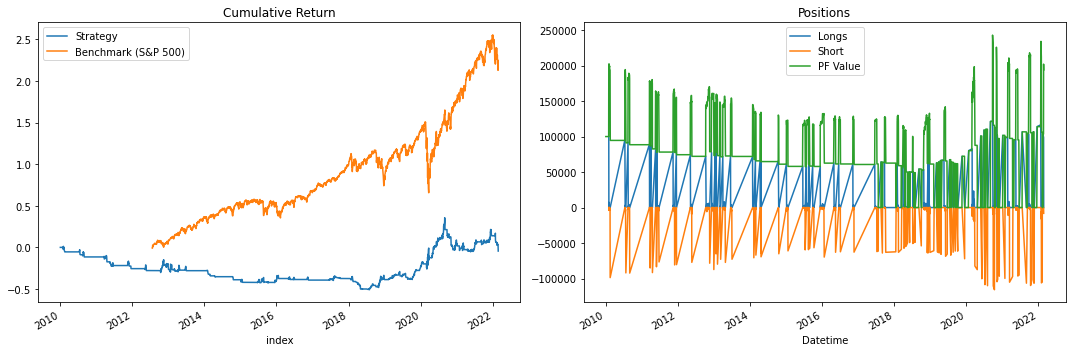

In [11]:
%matplotlib inline 

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

# Merge by date index. 
df_compare_benchmark = returns.to_frame("Strategy").join(df_benchmark.to_frame("Benchmark (S&P 500)"))

# Compute the cumulative return. 
df_compare_benchmark.add(1).cumprod().sub(1).plot(ax=axes[0], title="Cumulative Return")

# Plot. 
df_longs.plot(label="Longs", ax=axes[1], title="Positions")
df_short.plot(label="Short", ax=axes[1], title="Positions")
positions.cash.plot(label="PF Value", ax=axes[1])
axes[1].legend()

fig.tight_layout()

Start date,2012-07-24
End date,2022-02-25
Total months,115
,Backtest
Annual return,2.978%
Cumulative returns,32.479%
Annual volatility,19.08%
Sharpe ratio,0.25
Calmar ratio,0.07
Stability,0.26
Max drawdown,-42.34%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,42.34,2012-11-15,2018-07-30,2020-03-12,1911
1,30.07,2020-09-01,2021-05-20,NaT,NaN
2,14.38,2020-03-23,2020-03-26,2020-05-11,36
3,10.80,2020-03-12,2020-03-13,2020-03-16,3
4,4.80,2020-06-10,2020-06-11,2020-06-22,9


Stress Events,mean,min,max
US downgrade/European Debt Crisis,0.00%,0.00%,0.00%
Fukushima,0.08%,-1.94%,1.48%
EZB IR Event,0.00%,0.00%,0.00%
Flash Crash,0.00%,0.00%,0.00%
Apr14,-0.07%,-1.20%,0.48%
Oct14,-0.25%,-2.87%,0.00%
Fall2015,-0.11%,-5.77%,4.04%
Recovery,-0.03%,-7.22%,3.80%
New Normal,0.02%,-10.80%,16.17%


KeyError: 'US downgrade/European Debt Crisis'

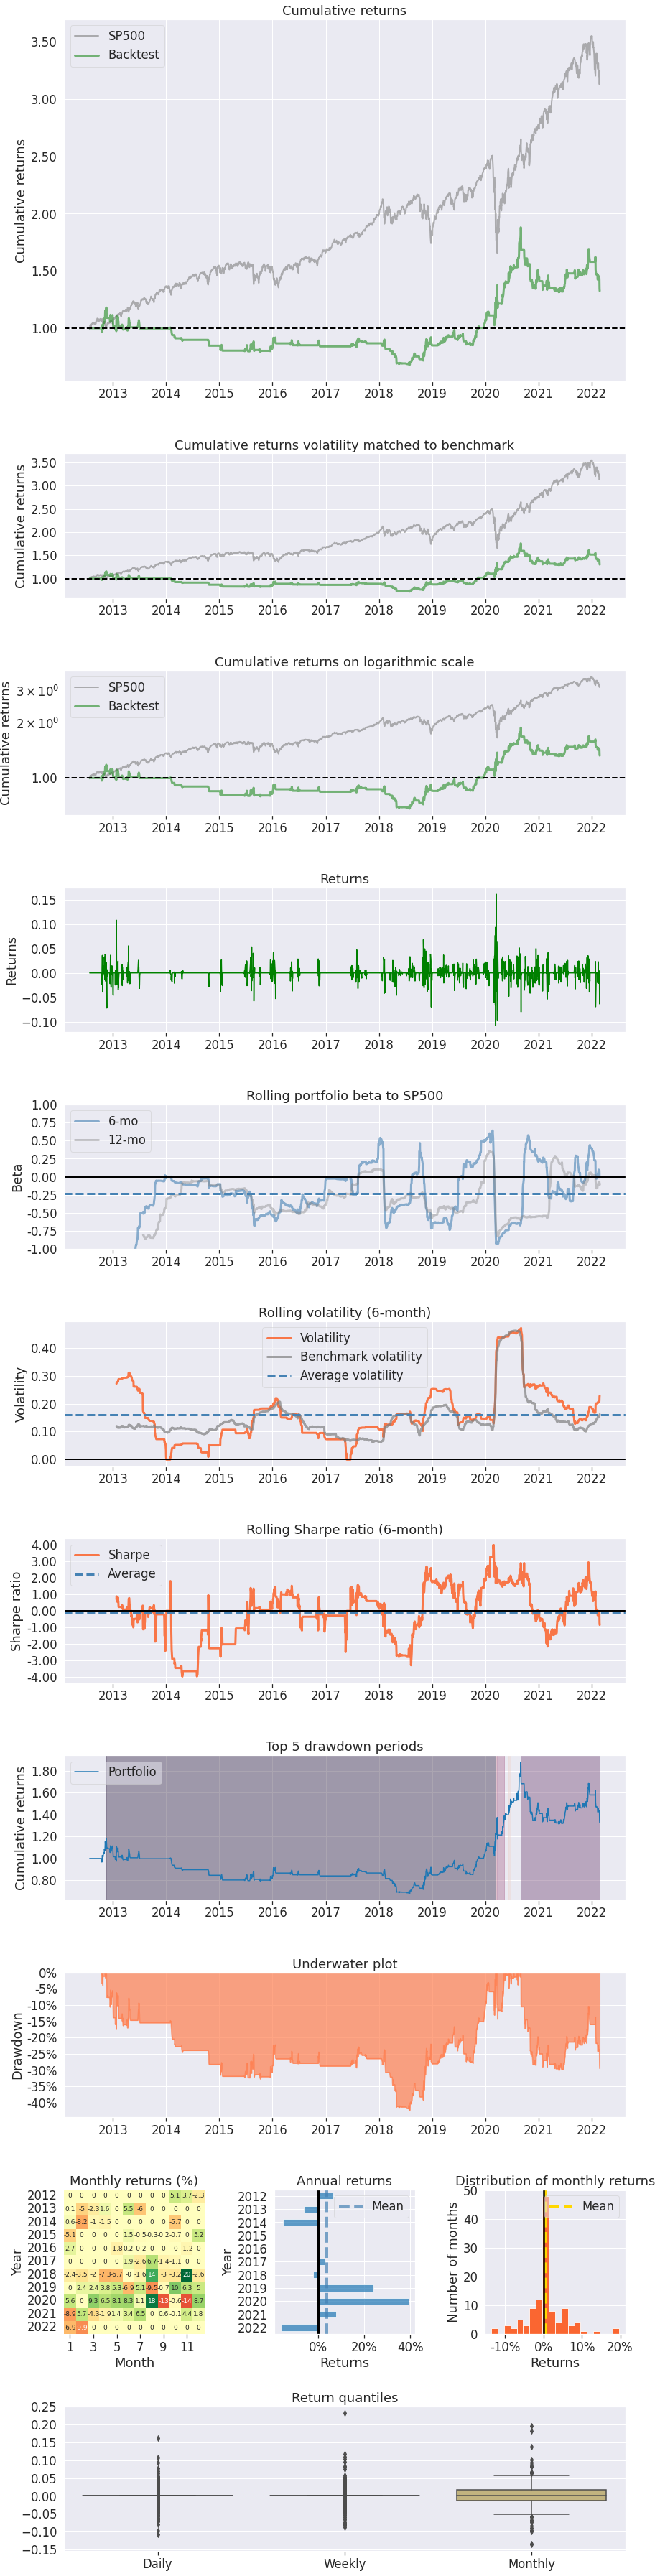

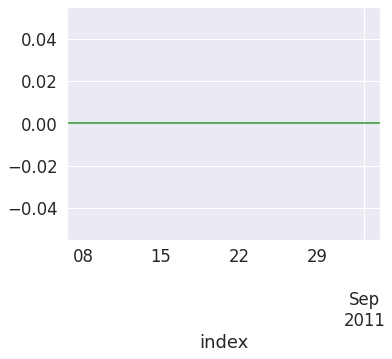

In [12]:
'''
Refer to this get the available functions for plotting: 
— https://mw572.github.io/All%20Weather%20V1/All%20Weather%20V1%20Full%20Analysis.html
— https://www.quantrocket.com/codeload/quant-finance-lectures/quant_finance_lectures/Lecture33-Portfolio-Analysis-with-pyfolio.ipynb.html
'''

%matplotlib inline 

# The datetime index from the benchmark must contain the extact dates. 
idx_benchmark = df_benchmark.index.difference(returns.index) 
idx_benchmark = df_benchmark.index.difference(idx_benchmark) 

pf.create_full_tear_sheet(
	returns,
	transactions=transactions,
	positions=positions,
	benchmark_rets=df_benchmark[idx_benchmark].dropna()
)